In [54]:
import torch
import numpy as np
import awkward as ak
import fastjet
import vector
import uproot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from matplotlib.lines import Line2D
from torch.distributions.categorical import Categorical


In [2]:
vector.register_awkward()

class ParticleClouds:
    def __init__(self, 
                 path, 
                 feats_continuous=['part_pt_log', 'part_etarel', 'part_phirel'],
                 features_discrete=['flavor', 'charge'], 
                 features_context=[],  
                 num_jets=None, 
                 max_num_particles=128, 
                 standardize_log_pt=True):

        data = self.read_root_file(path)
        self.max_num_particles = max_num_particles

        feats_continuous += ['mask']        
        continuous = torch.tensor(np.stack([ak.to_numpy(self.pad(data[feat], maxlen=max_num_particles)) for feat in feats_continuous] , axis=1))
        continuous = torch.permute(continuous, (0,2,1))
        continuous = continuous[:num_jets] if num_jets is not None else continuous        
        self.log_pt = (continuous[...,0] - torch.mean(continuous[...,0])) / torch.std(continuous[...,0]) if standardize_log_pt else continuous[...,0]
        self.eta = continuous[...,1]
        self.phi = continuous[...,2]
        self.mask = continuous[...,-1].long()
        self.continuous = torch.concat([self.log_pt.unsqueeze(dim=-1), self.eta.unsqueeze(dim=-1), self.phi.unsqueeze(dim=-1)], dim=2)
        self.multiplicity = torch.sum(self.mask, dim=1)
        
        if len(features_discrete):
            feats_discrete = ['part_isChargedHadron', 'part_isNeutralHadron', 'part_isPhoton', 'part_isElectron', 'part_isMuon', 'part_charge']
            discrete = torch.tensor(np.stack([ak.to_numpy(self.pad(data[feat], maxlen=max_num_particles)) for feat in feats_discrete], axis=1)).long()
            discrete = torch.permute(discrete, (0,2,1))
            discrete = discrete[: num_jets] if num_jets is not None else discrete
            self.isChargedHadron = discrete[...,0]
            self.isNeutralHadron = discrete[...,1]
            self.isPhoton = discrete[...,2]
            self.isElectron = discrete[...,3]
            self.isMuon = discrete[...,4]
            self.flavor = torch.argmax(discrete[...,0:5], dim=2)
            self.charge = discrete[...,5]
            self.discrete = torch.concat([self.flavor.unsqueeze(dim=-1), self.charge.unsqueeze(dim=-1)], dim=2)

    def __len__(self):
        return self.continuous.shape[0]
    
    def read_root_file(self, filepath):
        
        """Loads a single .root file from the JetClass dataset.
        """
        x = uproot.open(filepath)['tree'].arrays()
        x['part_pt'] = np.hypot(x['part_px'], x['part_py'])
        x['part_pt_log'] = np.log(x['part_pt'])
        x['part_ptrel'] = x['part_pt'] / x['jet_pt']
        x['part_deltaR'] = np.hypot(x['part_deta'], x['part_dphi'])

        p4 = vector.zip({'px': x['part_px'],
                         'py': x['part_py'],
                         'pz': x['part_pz'],
                         'energy': x['part_energy']})
        
        x['part_eta'] = p4.eta
        x['part_phi'] = p4.phi
        x['part_etarel'] = p4.eta - x['jet_eta'] 
        x['part_phirel'] = (p4.phi - x['jet_phi'] + np.pi) % (2 * np.pi) - np.pi
        x['mask'] = np.ones_like(x['part_energy']) 
        f = ak.concatenate([x['part_isChargedHadron'], x['part_isNeutralHadron'], x['part_isPhoton'], x['part_isElectron'], x['part_isMuon']], axis=1)
        x['flavor'] = ak.argmax(f, axis=1)
        return x
    
    def pad(self, a, maxlen, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
                return x
    
    def summary_stats(self):
        data = self.continuous[self.mask > 0]
        return {'mean': data.mean(0).numpy(),
                'std': data.std(0).numpy(),
                'min': data.min(0),
                'max': data.max(0)}
    
    def soft_ghosts_augmentation(self):
        x = torch.randn_like(self.mask.unsqueeze(-1))
        y = torch.randn_like(self.mask.unsqueeze(-1))
        z= torch.rand_like(self.mask.unsqueeze(-1)) * 0.07
        log_z = torch.log(z)
        ghosts = torch.stack([log_z, x, y], dim=2)
        self.continuous = self.continuous + ghosts * (~self.mask.unsqueeze(-1))

    def histogram(self, features='pt', num_bins=100, density=True, use_quantiles=False):
        mask = self.mask > 0
        x = getattr(self, features)[mask]
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.constituents.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wasserstein1D(self, feature, reference):
        mask = self.mask > 0
        x = getattr(self, feature)[mask]
        y = getattr(reference.constituents, feature)[mask]
        return scipy.stats.wasserstein_distance(x, y)

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        mask = self.mask > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        if isinstance(features, tuple):
            x = getattr(self, features[0])[mask] if idx is None else getattr(self, features[0])[:,idx]
            y = getattr(self, features[1])[mask] if idx is None else getattr(self, features[1])[:,idx]
            sns.histplot(x=x, y=y, ax=ax, **kwargs)
            ax.set_xlabel(features[0] if xlabel is None else xlabel)
            ax.set_ylabel(features[1] if ylabel is None else ylabel)
        else:
            x = getattr(self, features)[mask] if idx is None else getattr(self, features)[:,idx]
            sns.histplot(x=x, element="step", ax=ax, **kwargs) 
            ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def display_cloud(self, idx, ax=None, figsize=(3,3) , facecolor='whitesmoke', color='darkblue'):
            eta = self.eta[idx].numpy()
            phi = self.phi[idx].numpy()
            pt = np.exp(self.log_pt[idx].numpy())
            mask = list(self.mask[idx].numpy()>0)
            pt = pt[mask] 
            eta = eta[mask] 
            phi = phi[mask] 

            if ax is None: _, ax = plt.subplots(figsize=figsize)            
            
            if hasattr(self, 'flavor'):

                flavor = self.flavor[idx].numpy()
                charge = self.charge[idx].numpy()
                flavor = flavor[mask]
                charge = charge[mask]

                ax.scatter(eta[(flavor==0) & (charge<0)], phi[(flavor==0) & (charge<0)], marker='^', s=3*pt[(flavor==0) & (charge<0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==0) & (charge>0)], phi[(flavor==0) & (charge>0)], marker='v', s=3*pt[(flavor==0) & (charge>0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=3*pt[flavor==1], color='darkred', alpha=0.5,  label=r'$h^{0}$')
                ax.scatter(eta[flavor==2], phi[flavor==2], marker='o', s=3*pt[flavor==2], color='gold', alpha=0.5, label=r'$\gamma$')
                ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=3*pt[(flavor==3) & (charge<0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=3*pt[(flavor==3) & (charge>0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=3*pt[(flavor==4) & (charge<0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=3*pt[(flavor==4) & (charge>0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')

                # Define custom legend markers
                h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkblue', linestyle='None')
                h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h3 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
                h4 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='green', linestyle='None')
                h5 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='purple', linestyle='None')

                plt.legend([h1, h2, h3, h4, h5], 
                        [r'$h^{\pm}$', r'$h^{0}$', r'$\gamma$', '$e^{\pm}$', '$\mu^{\pm}$'], 
                        loc="upper right", 
                        markerscale=2, 
                        scatterpoints=1, 
                        fontsize=7,  
                        frameon=False,
                        ncol=8,
                        bbox_to_anchor=(0.625, 1.11),
                        handletextpad=-0.5,  
                        columnspacing=.1) 
            else:
                ax.scatter(eta, phi, marker='o', s=3*pt, color=color, alpha=0.5)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background


In [67]:
class NoiseClouds:
    def __init__(self, 
                num_clouds, 
                features_continuous=['part_pt_log', 'part_etarel', 'part_phirel'],
                features_discrete=['flavor', 'charge'],
                features_context=[],
                max_num_particles=128,
                standardize_log_pt=True,
                masks_like=None):
        self.num_clouds = num_clouds
        self.num_particles = max_num_particles 
        sigma = torch.sqrt(torch.tensor(2))
        pt = torch.exp(sigma * torch.randn((num_clouds, max_num_particles) ,))
        self.pt = torch.sort(pt, dim=1, descending=True)[0]
        self.sample_masks(masks_like=masks_like)
        self.log_pt = torch.log(self.pt) * self.mask
        self.log_pt = (self.log_pt - torch.mean(self.log_pt)) / torch.std(self.log_pt) if standardize_log_pt else self.log_pt
        self.eta = torch.randn((num_clouds, max_num_particles) ,) * self.mask
        self.phi = torch.randn((num_clouds, max_num_particles) ,) * self.mask
        self.continuous = torch.concat([self.log_pt.unsqueeze(dim=-1), self.eta.unsqueeze(dim=-1), self.phi.unsqueeze(dim=-1)], dim=2)
        self.multiplicity = torch.sum(self.mask, dim=1)

        if len(features_discrete)>0:
            flavor = np.random.choice([0,1,2,3,4], size=(num_clouds, max_num_particles))
            charge = np.random.choice([-1, 1], size=(num_clouds, max_num_particles))
            charge = np.where((flavor==1) | (flavor==2), 0, charge)
            self.flavor = torch.tensor(flavor).long()
            self.charge = torch.tensor(charge).long()
            self.discrete = torch.concat([self.flavor.unsqueeze(dim=-1), self.charge.unsqueeze(dim=-1)], dim=2)

            self.isChargedHadron = torch.zeros((num_clouds, max_num_particles))
            self.isNeutralHadron = torch.zeros((num_clouds, max_num_particles))
            self.isPhoton = torch.zeros((num_clouds, max_num_particles))
            self.isElectron = torch.zeros((num_clouds, max_num_particles))
            self.isMuon = torch.zeros((num_clouds, max_num_particles))

            self.isChargedHadron[self.flavor==0] = 1
            self.isNeutralHadron[self.flavor==1] = 1
            self.isPhoton[self.flavor==2] = 1
            self.isElectron[self.flavor==3] = 1
            self.isMuon[self.flavor==4] = 1

    def __len__(self):
        return self.num_clouds 
    
    def sample_masks(self, masks_like=None):
        if masks_like is None:   
            self.mask = torch.ones_like(self.pt) 
        else:
            masks_like = masks_like.multiplicity
            histogram = torch.tensor(np.histogram(masks_like, bins=np.arange(0, torch.max(masks_like).item(), 1))[0]).long()
            probs = histogram / histogram.sum()
            cat = Categorical(probs)
            N = cat.sample((len(self),))
            masks = torch.zeros((self.num_clouds, self.num_particles))
            for i, n in enumerate(N):
                masks[i, :n] = 1
            self.mask = masks.long()

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        mask = self.mask > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        if isinstance(features, tuple):
            x = getattr(self, features[0])[mask] if idx is None else getattr(self, features[0])[:,idx]
            y = getattr(self, features[1])[mask] if idx is None else getattr(self, features[1])[:,idx]
            sns.histplot(x=x, y=y, ax=ax, **kwargs)
            ax.set_xlabel(features[0] if xlabel is None else xlabel)
            ax.set_ylabel(features[1] if ylabel is None else ylabel)
        else:
            x = getattr(self, features)[mask] if idx is None else getattr(self, features)[:,idx]
            sns.histplot(x=x, element="step", ax=ax, **kwargs) 
            ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def summary_stats(self):
        data = self.continuous
        return {'mean': data.mean(0).numpy(),
                'std': data.std(0).numpy(),
                'min': data.min(0),
                'max': data.max(0)}

    def display_cloud(self, idx, ax=None, figsize=(3,3) , facecolor='whitesmoke', color='darkblue'):
            eta = self.eta[idx].numpy()
            phi = self.phi[idx].numpy()
            pt = np.exp(self.log_pt[idx].numpy())
            mask = list(self.mask[idx].numpy()>0)
            pt = pt[mask] 
            eta = eta[mask] 
            phi = phi[mask] 

            if ax is None: _, ax = plt.subplots(figsize=figsize)            
            
            if hasattr(self, 'flavor'):

                flavor = self.flavor[idx].numpy()
                charge = self.charge[idx].numpy()
                flavor = flavor[mask]
                charge = charge[mask]

                ax.scatter(eta[(flavor==0) & (charge<0)], phi[(flavor==0) & (charge<0)], marker='^', s=3*pt[(flavor==0) & (charge<0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==0) & (charge>0)], phi[(flavor==0) & (charge>0)], marker='v', s=3*pt[(flavor==0) & (charge>0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=3*pt[flavor==1], color='darkred', alpha=0.5,  label=r'$h^{0}$')
                ax.scatter(eta[flavor==2], phi[flavor==2], marker='o', s=3*pt[flavor==2], color='gold', alpha=0.5, label=r'$\gamma$')
                ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=3*pt[(flavor==3) & (charge<0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=3*pt[(flavor==3) & (charge>0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=3*pt[(flavor==4) & (charge<0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=3*pt[(flavor==4) & (charge>0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')

                # Define custom legend markers
                h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkblue', linestyle='None')
                h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h3 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
                h4 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='green', linestyle='None')
                h5 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='purple', linestyle='None')

                plt.legend([h1, h2, h3, h4, h5], 
                        [r'$h^{\pm}$', r'$h^{0}$', r'$\gamma$', '$e^{\pm}$', '$\mu^{\pm}$'], 
                        loc="upper right", 
                        markerscale=2, 
                        scatterpoints=1, 
                        fontsize=7,  
                        frameon=False,
                        ncol=8,
                        bbox_to_anchor=(0.625, 1.11),
                        handletextpad=-0.5,  
                        columnspacing=.1) 
            else:
                ax.scatter(eta, phi, marker='o', s=3*pt, color=color, alpha=0.5)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background


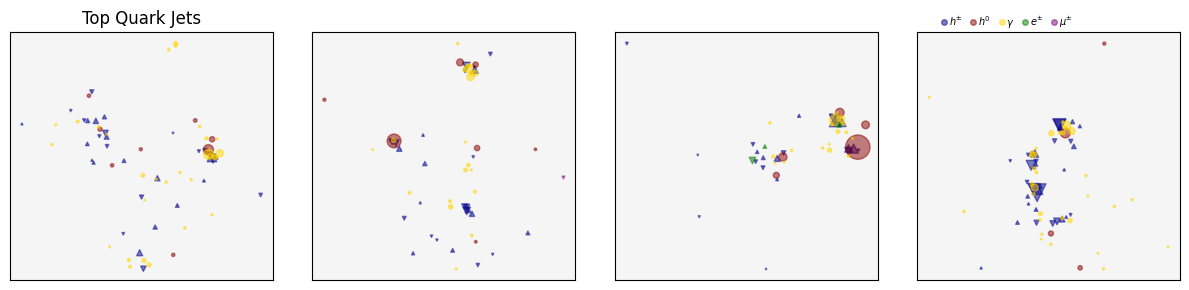

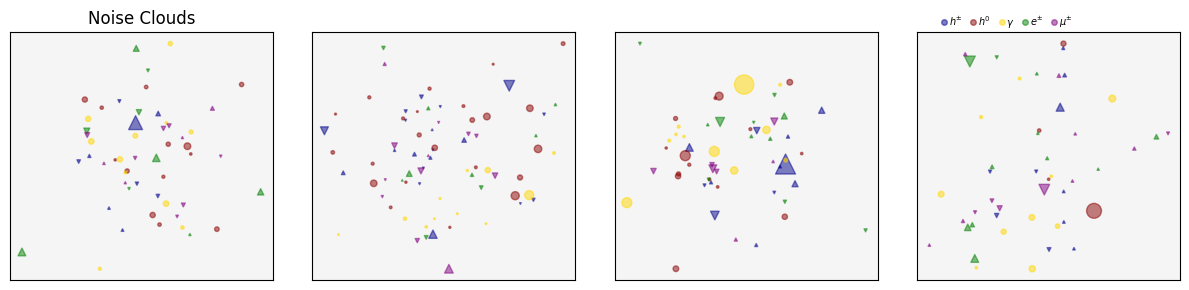

(100000, 100000, torch.Size([100000, 128, 3]), torch.Size([100000, 128, 3]))

In [68]:
# tops = ParticleClouds('/home/df630/CMB/data/JetClass/TTBar_000.root', max_num_particles=128)
noise = NoiseClouds(tops.continuous.shape[0], max_num_particles=128, masks_like=tops)

fig, ax = plt.subplots(1, 4, figsize=(12,3)) 
tops.display_cloud(idx=0, ax=ax[0])
tops.display_cloud(idx=1, ax=ax[1])
tops.display_cloud(idx=2, ax=ax[2])
tops.display_cloud(idx=3, ax=ax[3])
ax[0].set_title('Top Quark Jets')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(12,3)) 
noise.display_cloud(idx=0, ax=ax[0])
noise.display_cloud(idx=1, ax=ax[1])
noise.display_cloud(idx=2, ax=ax[2])
noise.display_cloud(idx=3, ax=ax[3])
ax[0].set_title('Noise Clouds')
plt.tight_layout()
plt.show()

len(tops), len(noise), tops.continuous.shape, noise.continuous.shape



In [71]:
noise.mask.sum(1)

tensor([53, 74, 56,  ..., 53, 45, 41])

In [52]:
import torch
from torch.distributions.categorical import Categorical
import numpy as np

histogram = torch.tensor(np.histogram(tops.multiplicity, bins=np.arange(0, torch.max(tops.multiplicity).item(), 1))[0]).long()
probs = histogram / histogram.sum()
m = Categorical(probs)

gen_sample = m.sample((1000000,))


<Axes: ylabel='Density'>

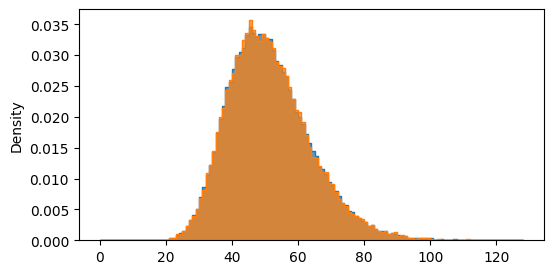

In [73]:
fig,ax = plt.subplots(figsize=(6,3))
sns.histplot(tops.multiplicity, element='step', binrange=(0, 128), binwidth=1, stat='density', ax=ax)
sns.histplot(noise.mask.sum(1), element='step', binrange=(0,128), binwidth=1, stat='density', ax=ax)

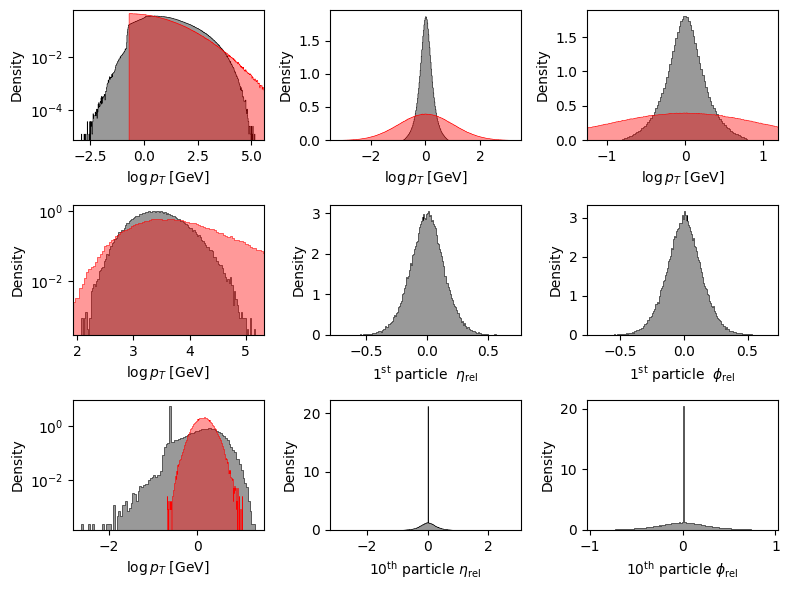

In [5]:
_, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,6))

plot_args_0 = {'alpha': 0.4,
             'lw': 0.4, 
             'log_scale': (False, True), 
             'stat': 'density'}

plot_args_1 = {'alpha': 0.4,
             'lw': 0.4, 
             'log_scale': (False, False), 
             'stat': 'density'}

tops.histplot('log_pt', xlabel=r'$\log p_T$ [GeV]',  ax=ax[0,0], label='top', color='k', **plot_args_0)
noise.histplot('log_pt', xlabel=r'$\log p_T$ [GeV]',  ax=ax[0,0], label='top', color='r', **plot_args_0)
tops.histplot('eta', xlabel=r'$\eta_{\rm rel}$', binwidth=0.02, ax=ax[0,1], color='k', **plot_args_1)
noise.histplot('eta', xlabel=r'$\log p_T$ [GeV]',  ax=ax[0,1], label='top', color='r', **plot_args_1)
tops.histplot('phi', xlabel=r'$\phi_{\rm rel}$', binwidth=0.02, ax=ax[0,2], color='k', **plot_args_1)
noise.histplot('phi', xlabel=r'$\log p_T$ [GeV]',  ax=ax[0,2], label='top', color='r', **plot_args_1)

tops.histplot('log_pt', idx=0, xlabel=r'1$^{\rm st}$ particle $log p_T$ [GeV]', color='k', ax=ax[1,0], **plot_args_0)
noise.histplot('log_pt',  idx=0, xlabel=r'$\log p_T$ [GeV]',  ax=ax[1,0], label='top', color='r', **plot_args_0)
tops.histplot('eta', idx=0, xlabel=r'1$^{\rm st}$ particle  $\eta_{\rm rel}$', color='k', ax=ax[1,1], **plot_args_1)
tops.histplot('phi', idx=0, xlabel=r'1$^{\rm st}$ particle  $\phi_{\rm rel}$', color='k',  ax=ax[1,2], **plot_args_1)

tops.histplot('log_pt', idx=40, xlabel=r'10$^{\rm th}$ particle $log p_T$ [GeV]', color='k', ax=ax[2,0], **plot_args_0)
noise.histplot('log_pt', idx=40, xlabel=r'$\log p_T$ [GeV]',  ax=ax[2,0], label='top', color='r', **plot_args_0)
tops.histplot('eta', idx=40, xlabel=r'10$^{\rm th}$ particle $\eta_{\rm rel}$', color='k', ax=ax[2,1], **plot_args_1)
tops.histplot('phi', idx=40, xlabel=r'10$^{\rm th}$ particle $\phi_{\rm rel}$', color='k', ax=ax[2,2], **plot_args_1)

plt.tight_layout()

<Axes: ylabel='Count'>

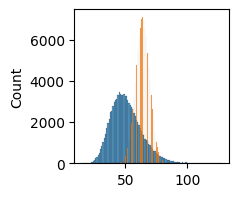

In [6]:
fig,ax = plt.subplots(figsize=(2,2))
sns.histplot(tops.multiplicity,  ax=ax, discrete=True)
sns.histplot(noise.multiplicity , ax=ax, )
